In [32]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/forward_dynamics`


In [33]:
import PyPlot as plt
using PyCall
using JLD2
using Graphs
using LaTeXStrings

# Paper plot

In [34]:
labels = Dict("EPI"=>"SCDC","MFstandard"=>"SMF","SIB"=>"BP","sampling"=>"MCMC")
colors =  Dict("EPI"=>"C0","MFstandard"=>"C1","SIB"=>"C2","sampling"=>"C3")
markers = Dict("EPI"=>"o","MFstandard"=>"s","SIB"=>"^","sampling"=>"v")
linestyle = Dict("EPI"=>"-","MFstandard"=>":","SIB"=>"-.","sampling"=>"--");

In [35]:
T = 50
data_dict = Dict("Bethe"=> load("Bethe.jld2"), 
                "RRG4"=>load("RRG4.jld2"), 
                "RRG15"=>load("RRG15.jld2"), 
                "Prox"=>load("Prox.jld2"));

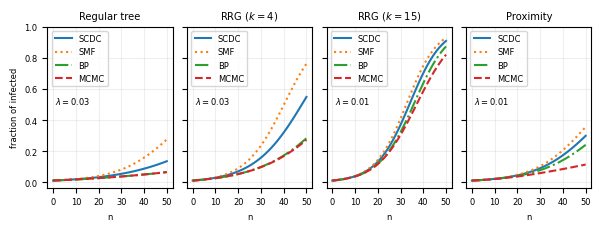

In [36]:
fig, axs = plt.subplots(1,4, figsize = (6,2.3), sharey=true, tight_layout=true)
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 6  # Set font size


titles_dict = Dict("Bethe"=>"Regular tree", "RRG4"=>string("RRG ",L"(k=4)"), "RRG15"=>string("RRG ",L"(k=15)"), "Prox"=>"Proximity")

for (ix, x) in enumerate(["Bethe", "RRG4", "RRG15", "Prox"])
    for meth in ["EPI", "MFstandard", "SIB"]
        #println(x, "  ", meth, "ok")
        axs[ix].plot(0:T, data_dict[x]["data"][meth], color=colors[meth], label=labels[meth], lw=1.5, linestyle=linestyle[meth])
    end
    axs[ix].plot(0:T, data_dict[x]["data"]["sampling"], color=colors["sampling"], label=labels["sampling"], linestyle=linestyle["sampling"], lw=1.5)
    axs[ix].set_title(titles_dict[x])
    axs[ix].tick_params(axis = "both")
    axs[ix].set_xticks([0] ∪ collect(10:10:50))
    axs[ix].grid(alpha=.2)
    axs[ix].legend(loc="upper left")    
    lamb = data_dict[x]["params"][1]
    axs[ix].text(1, .5, string(L"\lambda = %$lamb"))
    axs[ix].set_xlabel("n")
end

axs[1].set_yticks(.0:.2:1)
axs[1].set_ylabel("fraction of infected")

plt.display(fig)
fig.savefig("newres_fwd2.pdf", format="pdf", bbox_inches="tight")

# Appendix figure

In [53]:
labels = Dict("EPI"=>"SCDC","EPIapprox"=>"SCDCa","MF"=>"SMF","SIB"=>"BP","sampling"=>"MCMC")
colors =  Dict("EPI"=>"C0","MF"=>"C1","SIB"=>"C2","sampling"=>"C3","EPIapprox"=>"C4")
markers = Dict("EPI"=>"o","MF"=>"s","SIB"=>"^","sampling"=>"v","EPIapprox"=>"d")
linestyle = Dict("EPI"=>"-","MF"=>":","SIB"=>"-.","sampling"=>"--","EPIapprox"=>(0, (3, 5, 1, 5, 1, 5)));


graph_types = ["Bethe", "RRG4", "RRG15", "Prox"]
titles_dict = Dict("Bethe"=>"Regular tree", "RRG4"=>string("RRG ",L"(k=4)"), "RRG15"=>string("RRG ",L"(k=15)"), "Prox"=>"Proximity")
tmax = Dict("Bethe"=>25, "RRG4"=>25, "RRG15"=>15, "Prox"=>15)
NVs = Dict("Bethe"=>485, "RRG4"=>500, "RRG15"=>500, "Prox"=>500)

data = Dict("Bethe"=>JLD2.load("res_lambda/bethe_N-485_K-4_tmax-5_nsrc-5.jld2"),
            "RRG4"=>JLD2.load("res_lambda/RRG_N-500_K-4_nsrc-5.jld2"),
            "RRG15"=>JLD2.load("res_lambda/RRG_N-500_K-15_nsrc-5.jld2"),
            "Prox"=>JLD2.load("res_lambda/Prox_N-500_lmax-0.075_nsrc-5.jld2"))

data["Bethe"]["res"][0.3]


Dict{String, Vector{Float64}} with 5 entries:
  "MF"        => [5.0, 7.95382, 13.4649, 23.3296, 40.4849, 68.8578, 111.858, 16…
  "SIB"       => [5.0, 7.95382, 11.7451, 16.3338, 21.8138, 28.3076, 35.9427, 44…
  "EPIapprox" => [5.0, 7.95382, 12.6071, 19.6164, 29.909, 44.6421, 65.0476, 92.…
  "sampling"  => [4.9926, 7.9457, 11.7324, 16.3264, 21.7347, 28.1886, 35.8198, …
  "EPI"       => [5.0, 8.50338, 14.3828, 23.6868, 37.9081, 58.7764, 87.7432, 12…

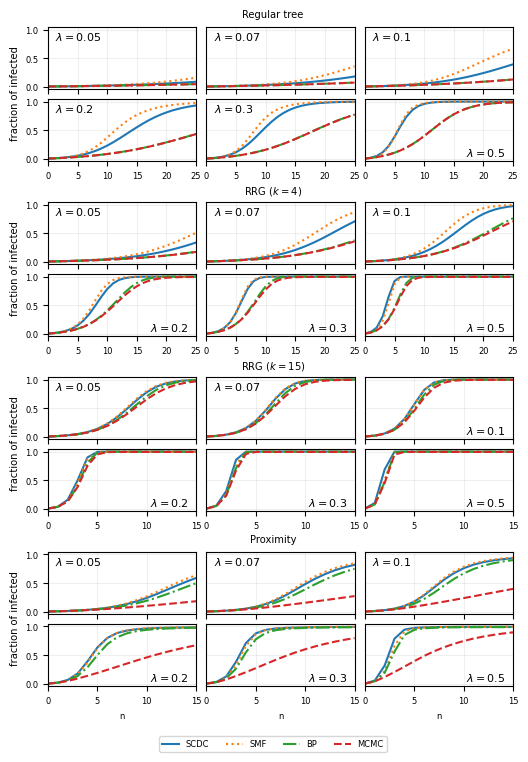

In [54]:
fig = plt.figure(figsize = (6,7)) 
subfigs = fig.subfigures(4, 1, hspace=0)  # One subfigure for each graph type

function draw_λval!(ax, i, g, λ)
    pos = Dict("Bethe"=>5, "RRG4"=>3, "RRG15"=>2, "Prox"=>3)
    if i > pos[g]
        ax.text(0.95, 0.05, L"\lambda = %$λ", transform=ax.transAxes, fontsize=8, verticalalignment="bottom", horizontalalignment="right")
    else
        ax.text(0.05, 0.95, L"\lambda = %$λ", transform=ax.transAxes, fontsize=8, verticalalignment="top", horizontalalignment="left")
    end
end


for (gix, graph) in enumerate(graph_types)
    λvec = data[graph]["lambdavec"]
    res = data[graph]["res"]
    
    subfig = subfigs[gix]
    subfig.suptitle(titles_dict[graph])  # Add title for the graph type
    
    axs = subfig.subplots(2, 3, sharex=true, sharey=true, gridspec_kw=Dict("hspace"=>0.15, "wspace"=>0.07))  # 2x2 grid of plots for λ values
    axs = [axs[i,j] for i in 1:2 for j in 1:3]
    
    for (ix, λ) in enumerate(λvec)
        ax = axs[ix]
        
        ax.set_xlim(0,tmax[graph])

        for meth in ["EPI", "MF", "SIB", "sampling"]
            if ix==1 && graph=="Bethe"
                ax.plot(0:tmax[graph], res[λ][meth][1:tmax[graph]+1] ./ NVs[graph], color=colors[meth], lw=1.5, linestyle=linestyle[meth], label=labels[meth])
            else
                ax.plot(0:tmax[graph], res[λ][meth][1:tmax[graph]+1] ./ NVs[graph], color=colors[meth], lw=1.5, linestyle=linestyle[meth])
            end
        end

        # Add infection probability inside the plot
        if ix ∈ 1:3
            ax.tick_params(
                axis="x",          # changes apply to the x-axis
                which="both",      # both major and minor ticks are affected
                bottom=true,      # ticks along the bottom edge are off
                top=false,         # ticks along the top edge are off
                labelbottom=false,
                ) # labels along the bottom edge are off
        end
        
        if ix ∉ [1,4]
            ax.tick_params(
                axis="y",          # changes apply to the x-axis
                which="both",      # both major and minor ticks are affected
                left=false,      # ticks along the bottom edge are off
                right=false,         # ticks along the top edge are off
                labelleft=false,
                ) # labels along the bottom edge are off
        end
        
        draw_λval!(ax, ix, graph, λ)
        ax.grid(alpha=0.2)
        
        if ix ∈ 4:6 && graph=="Prox"
            ax.set_xlabel("n")
        end
        
        subfig.supylabel("fraction of infected", x=.07, y=0.5, verticalalignment="center", horizontalalignment="center")
    end
end

# Add a legend outside all subfigures
fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, -0.055),
    ncol=5
)

plt.display(fig)
fig.savefig("varlambda_fwd2.pdf", format="pdf", bbox_inches="tight")

# Reviewers response

In [39]:
data = JLD2.load("data_keep0I.jld2", "data")

Dict{String, Dict} with 4 entries:
  "RRG15" => Dict{Int64, Dict{String, Any}}(5=>Dict("adj"=>sparse([83, 124, 131…
  "Bethe" => Dict{String, Any}("adj"=>sparse([2, 3, 4, 5, 1, 6, 7, 8, 1, 9  …  …
  "Prox"  => Dict{Int64, Dict{String, Any}}(5=>Dict("lmax"=>0.075, "adj"=>spars…
  "RRG4"  => Dict{Int64, Dict{String, Any}}(5=>Dict("adj"=>sparse([10, 118, 439…

In [40]:
labels = Dict("EPI"=>"SCDC","MF"=>"SMF","SIB"=>"BP","sampling"=>"MCMC")
colors =  Dict("EPI"=>"C0","MF"=>"C1","SIB"=>"C2","sampling"=>"C3")
markers = Dict("EPI"=>"o","MF"=>"s","SIB"=>"^","sampling"=>"v")
linestyle = Dict("EPI"=>"-","MF"=>":","SIB"=>"-.","sampling"=>"--");

## Bethe lattice

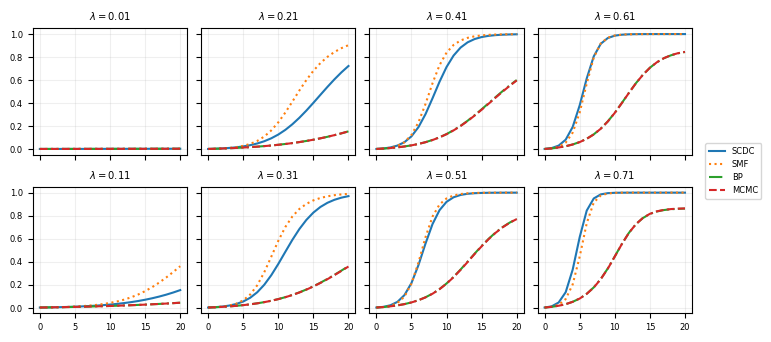

8


In [41]:
data_bethe = data["Bethe"]
λvec = data_bethe["lambdavec"][1:10:end]
res = data_bethe["res"]

println(length(λvec))

fig, axs = plt.subplots(2,4, figsize = (7,3.4), sharex=true, sharey=true, tight_layout=true)

for (ix, λ) in enumerate(λvec)
    for meth in ["EPI", "MF", "SIB", "sampling"]
        if ix == 1
            axs[ix].plot(0:20, res[λ][meth][1:21], color=colors[meth], label=labels[meth], lw=1.5, linestyle=linestyle[meth])
        else
            axs[ix].plot(0:20, res[λ][meth][1:21], color=colors[meth], lw=1.5, linestyle=linestyle[meth])
        end
    end
    axs[ix].set_title(string(L"\lambda = %$λ"))
    axs[ix].grid(alpha=.2)
end

fig.legend(
    loc="center left",       # Position the legend at the top center
    bbox_to_anchor=(1, .5),  # Position slightly above the subplots
    ncol=1,                    # Horizontal arrangement of item
)

plt.display(fig)


## RRG, K=4

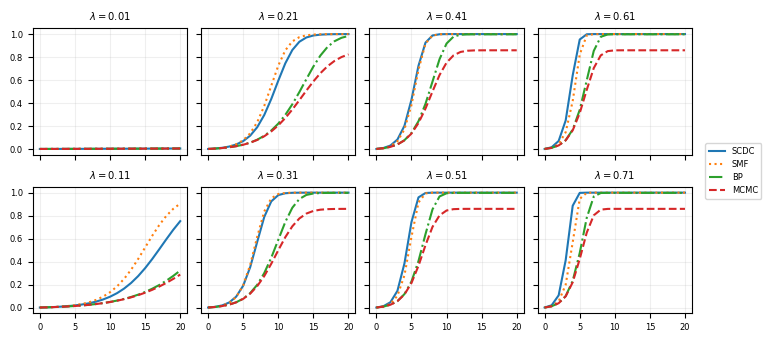

8


In [42]:
data_RRG4 = data["RRG4"][1]
λvec = data_RRG4["lambdavec"][1:10:end]
res = data_RRG4["res"]

println(length(λvec))

fig, axs = plt.subplots(2,4, figsize = (7,3.4), sharex=true, sharey=true, tight_layout=true)

for (ix, λ) in enumerate(λvec)
    for meth in ["EPI", "MF", "SIB", "sampling"]
        if ix == 1
            axs[ix].plot(0:20, res[λ][meth][1:21], color=colors[meth], label=labels[meth], lw=1.5, linestyle=linestyle[meth])
        else
            axs[ix].plot(0:20, res[λ][meth][1:21], color=colors[meth], lw=1.5, linestyle=linestyle[meth])
        end
    end
    axs[ix].set_title(string(L"\lambda = %$λ"))
    axs[ix].grid(alpha=.2)
end

fig.legend(
    loc="center left",       # Position the legend at the top center
    bbox_to_anchor=(1, .5),  # Position slightly above the subplots
    ncol=1,                    # Horizontal arrangement of item
)

plt.display(fig)


## RRG, K=15

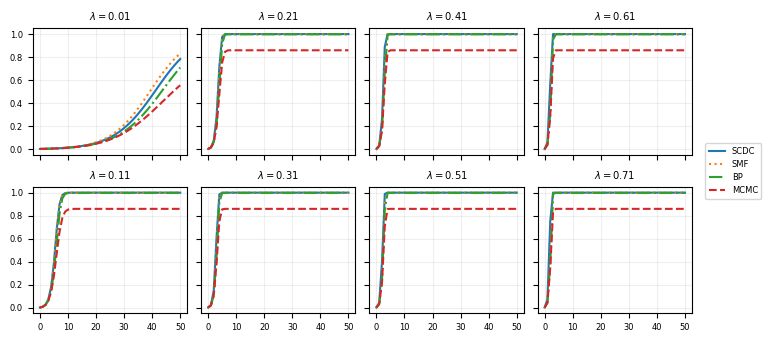

8


In [43]:
data_RRG15 = data["RRG15"][1]
λvec = data_RRG15["lambdavec"][1:10:end]
res = data_RRG15["res"]

println(length(λvec))

fig, axs = plt.subplots(2,4, figsize = (7,3.4), sharex=true, sharey=true, tight_layout=true)

for (ix, λ) in enumerate(λvec)
    for meth in ["EPI", "MF", "SIB", "sampling"]
        if ix == 1
            axs[ix].plot(0:T, res[λ][meth], color=colors[meth], label=labels[meth], lw=1.5, linestyle=linestyle[meth])
        else
            axs[ix].plot(0:T, res[λ][meth], color=colors[meth], lw=1.5, linestyle=linestyle[meth])
        end
    end
    axs[ix].set_title(string(L"\lambda = %$λ"))
    axs[ix].grid(alpha=.2)
end

fig.legend(
    loc="center left",       # Position the legend at the top center
    bbox_to_anchor=(1, .5),  # Position slightly above the subplots
    ncol=1,                    # Horizontal arrangement of item
)

plt.display(fig)


## Proximity

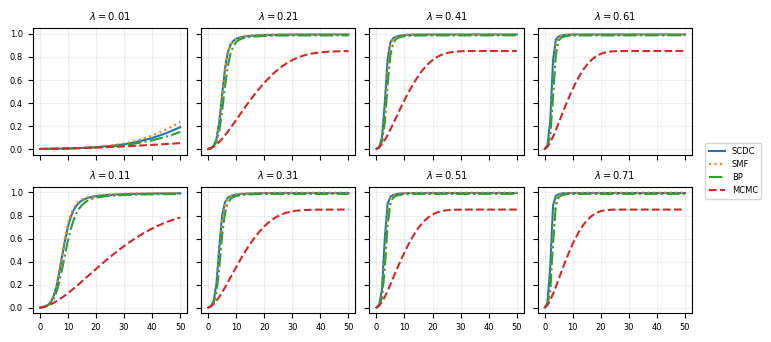

8


In [44]:
data_prox = data["Prox"][1]
λvec = data_prox["lambdavec"][1:10:end]
res = data_prox["res"]

println(length(λvec))

fig, axs = plt.subplots(2,4, figsize = (7,3.4), sharex=true, sharey=true, tight_layout=true)

for (ix, λ) in enumerate(λvec)
    for meth in ["EPI", "MF", "SIB", "sampling"]
        if ix == 1
            axs[ix].plot(0:T, res[λ][meth], color=colors[meth], label=labels[meth], lw=1.5, linestyle=linestyle[meth])
        else
            axs[ix].plot(0:T, res[λ][meth], color=colors[meth], lw=1.5, linestyle=linestyle[meth])
        end
    end
    axs[ix].set_title(string(L"\lambda = %$λ"))
    axs[ix].grid(alpha=.2)
end

fig.legend(
    loc="center left",       # Position the legend at the top center
    bbox_to_anchor=(1, .5),  # Position slightly above the subplots
    ncol=1,                    # Horizontal arrangement of item
)

plt.display(fig)
